Mount Google Drive

In [0]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Call the heavenly GODs

In [0]:
#Call all the heavenly GODs :)

%tensorflow_version 1.x

import numpy as np
import pandas as pd
import cv2
import json

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import os
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.utils import plot_model


Using TensorFlow backend.


Load Data for Training

In [0]:
!unzip -q "/content/gdrive/My Drive/dataset/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

gdrive/  hvc_annotations.csv  resized/  sample_data/


In [0]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

gender imagequality    age  ...        emotion        bodypose     image_path
0    male      Average  35-45  ...        Neutral  Front-Frontish  resized/1.jpg
1  female      Average  35-45  ...  Angry/Serious  Front-Frontish  resized/2.jpg
2    male         Good  45-55  ...        Neutral  Front-Frontish  resized/3.jpg
3    male         Good  45-55  ...        Neutral  Front-Frontish  resized/4.jpg
4  female         Good  35-45  ...        Neutral  Front-Frontish  resized/5.jpg

[5 rows x 9 columns]

In [0]:
# one hot encoding of labels
one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

0  ...              4
image_path                            resized/1.jpg  ...  resized/5.jpg
gender_female                                     0  ...              1
gender_male                                       1  ...              0
imagequality_Average                              1  ...              0
imagequality_Bad                                  0  ...              0
imagequality_Good                                 0  ...              1
age_15-25                                         0  ...              0
age_25-35                                         0  ...              0
age_35-45                                         1  ...              1
age_45-55                                         0  ...              0
age_55+                                           0  ...              0
weight_normal-healthy                             1  ...              0
weight_over-weight                                0  ...              0
weight_slightly-overweight                        0  ...              1
weight_underweight                                0  ...              0
carryingbag_Daily/Office/Work Bag                 0  ...              0
carryingbag_Grocery/Home/Plastic Bag              1  ...              0
carryingbag_None                                  0  ...              1
footwear_CantSee                                  0  ...              1
footwear_Fancy                                    0  ...              0
footwear_Normal                                   1  ...              0
emotion_Angry/Serious                             0  ...              0
emotion_Happy                                     0  ...              0
emotion_Neutral                                   1  ...              1
emotion_Sad                                       0  ...              0
bodypose_Back                                     0  ...              0
bodypose_Front-Frontish                           1  ...              1
bodypose_Side                                     0  ...              0

[28 rows x 5 columns]

In [0]:
display(one_hot_df)

image_path  gender_female  ...  bodypose_Front-Frontish  bodypose_Side
0          resized/1.jpg              0  ...                        1              0
1          resized/2.jpg              1  ...                        1              0
2          resized/3.jpg              0  ...                        1              0
3          resized/4.jpg              0  ...                        1              0
4          resized/5.jpg              1  ...                        1              0
...                  ...            ...  ...                      ...            ...
13568  resized/13570.jpg              0  ...                        1              0
13569  resized/13571.jpg              1  ...                        1              0
13570  resized/13572.jpg              1  ...                        0              1
13571  resized/13573.jpg              1  ...                        1              0
13572  resized/13574.jpg              0  ...                        1              0

[13573 rows x 28 columns]

In [0]:
one_hot_df.shape

(13573, 28)

In [0]:
# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""
    
    def __init__(self, df, batch_size=32, shuffle=True, augmentation=None):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        #image augmentation code
        self.augmentation = augmentation

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        #image augmentation code
        if self.augmentation is not None:
          image = self.augmentation.flow(image, shuffle=False).next()
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [0]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15, random_state=42)
print(train_df.shape, val_df.shape)

(11537, 28) (2036, 28)


Image Augmentation

In [0]:
from imgaug import augmenters as iaa

aug1 = iaa.CoarseDropout(p=0.10, size_percent=0.05)

def additional_augmenation(image):
    image = aug1.augment_image(image)

    return image

In [0]:
# create train and validation data generators

train_gen = PersonDataGenerator(train_df, 
                                batch_size=32, 
                                augmentation=ImageDataGenerator( 
                                    # set input mean to 0 over the dataset 
                                    featurewise_center=False, 
                                    # set each sample mean to 0 
                                    samplewise_center=False, 
                                    # divide inputs by std of dataset 
                                    featurewise_std_normalization=False, 
                                    # divide each input by its std 
                                    samplewise_std_normalization=False, 
                                    # apply ZCA whitening 
                                    zca_whitening=False, 
                                    # epsilon for ZCA whitening 
                                    zca_epsilon=1e-06, 
                                    # randomly rotate images in the range (deg 0 to 180) 
                                    rotation_range=0, 
                                    # randomly shift images horizontally 
                                    width_shift_range=0.1, 
                                    # randomly shift images vertically 
                                    height_shift_range=0.1, 
                                    # set range for random shear 
                                    shear_range=0.15, 
                                    # set range for random zoom 
                                    zoom_range=0., 
                                    # set range for random channel shifts 
                                    channel_shift_range=0., 
                                    # set mode for filling points outside the input boundaries 
                                    fill_mode='nearest', 
                                    # value used for fill_mode = "constant" 
                                    cval=0., 
                                    # randomly flip images 
                                    horizontal_flip=True, 
                                    # randomly flip images 
                                    vertical_flip=False, 
                                    # set rescaling factor (applied before any other transformation) 
                                    rescale=None, 
                                    # set function that will be applied on each input 
                                    preprocessing_function=additional_augmenation, 
                                    # image data format, either "channels_first" or "channels_last" 
                                    data_format=None, 
                                    # fraction of images reserved for validation (strictly between 0 and 1) 
                                    validation_split=0.0))

valid_gen = PersonDataGenerator(val_df, batch_size=64, shuffle=False)

In [0]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

Gender :  [1 0]
Image Quality :  [1 0 0]
Age :  [0 0 0 0 1]
Bag :  [0 0 1]
Pose :  [0 1 0]
Weight :  [1 0 0 0]
Footwear :  [1 0 0]
Emotion :  [0 0 0 1]
Shape:  (224, 224, 3)


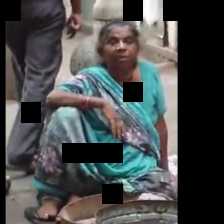

Gender :  [0 1]
Image Quality :  [1 0 0]
Age :  [1 0 0 0 0]
Bag :  [1 0 0]
Pose :  [0 1 0]
Weight :  [1 0 0 0]
Footwear :  [0 1 0]
Emotion :  [0 0 1 0]
Shape:  (224, 224, 3)


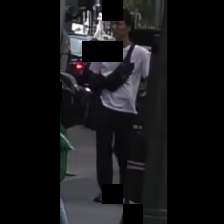

Gender :  [0 1]
Image Quality :  [1 0 0]
Age :  [0 0 1 0 0]
Bag :  [0 0 1]
Pose :  [0 1 0]
Weight :  [1 0 0 0]
Footwear :  [1 0 0]
Emotion :  [0 0 1 0]
Shape:  (224, 224, 3)


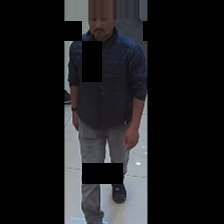

Gender :  [1 0]
Image Quality :  [1 0 0]
Age :  [0 1 0 0 0]
Bag :  [0 0 1]
Pose :  [0 0 1]
Weight :  [0 0 1 0]
Footwear :  [1 0 0]
Emotion :  [0 0 1 0]
Shape:  (224, 224, 3)


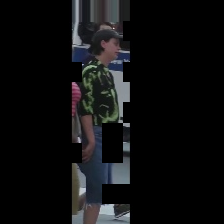

Gender :  [1 0]
Image Quality :  [0 0 1]
Age :  [0 1 0 0 0]
Bag :  [0 0 1]
Pose :  [0 1 0]
Weight :  [1 0 0 0]
Footwear :  [0 0 1]
Emotion :  [0 0 0 1]
Shape:  (224, 224, 3)


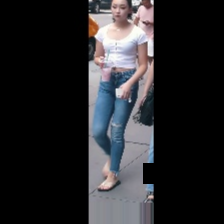

Gender :  [1 0]
Image Quality :  [0 0 1]
Age :  [1 0 0 0 0]
Bag :  [1 0 0]
Pose :  [0 1 0]
Weight :  [1 0 0 0]
Footwear :  [0 0 1]
Emotion :  [0 1 0 0]
Shape:  (224, 224, 3)


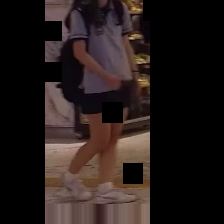

Gender :  [1 0]
Image Quality :  [1 0 0]
Age :  [0 1 0 0 0]
Bag :  [0 0 1]
Pose :  [1 0 0]
Weight :  [1 0 0 0]
Footwear :  [0 0 1]
Emotion :  [0 0 1 0]
Shape:  (224, 224, 3)


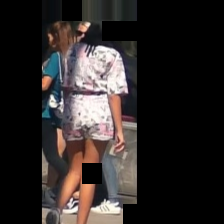

Gender :  [0 1]
Image Quality :  [0 0 1]
Age :  [0 1 0 0 0]
Bag :  [1 0 0]
Pose :  [0 1 0]
Weight :  [1 0 0 0]
Footwear :  [0 0 1]
Emotion :  [0 0 1 0]
Shape:  (224, 224, 3)


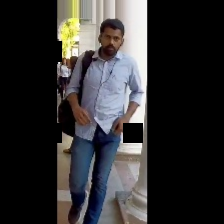

Gender :  [1 0]
Image Quality :  [1 0 0]
Age :  [0 0 0 1 0]
Bag :  [0 0 1]
Pose :  [1 0 0]
Weight :  [1 0 0 0]
Footwear :  [0 1 0]
Emotion :  [0 0 1 0]
Shape:  (224, 224, 3)


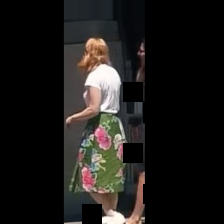

Gender :  [0 1]
Image Quality :  [1 0 0]
Age :  [0 1 0 0 0]
Bag :  [0 0 1]
Pose :  [0 1 0]
Weight :  [1 0 0 0]
Footwear :  [0 1 0]
Emotion :  [0 0 1 0]
Shape:  (224, 224, 3)


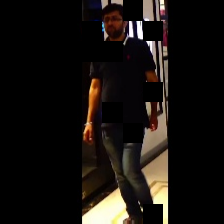

Gender :  [1 0]
Image Quality :  [0 1 0]
Age :  [0 1 0 0 0]
Bag :  [1 0 0]
Pose :  [0 1 0]
Weight :  [1 0 0 0]
Footwear :  [0 1 0]
Emotion :  [1 0 0 0]
Shape:  (224, 224, 3)


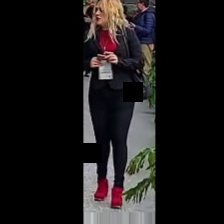

Gender :  [0 1]
Image Quality :  [0 1 0]
Age :  [0 1 0 0 0]
Bag :  [0 0 1]
Pose :  [0 1 0]
Weight :  [1 0 0 0]
Footwear :  [1 0 0]
Emotion :  [0 0 1 0]
Shape:  (224, 224, 3)


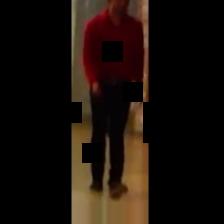

Gender :  [0 1]
Image Quality :  [0 0 1]
Age :  [1 0 0 0 0]
Bag :  [0 0 1]
Pose :  [0 0 1]
Weight :  [1 0 0 0]
Footwear :  [1 0 0]
Emotion :  [1 0 0 0]
Shape:  (224, 224, 3)


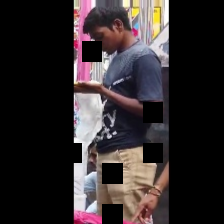

Gender :  [0 1]
Image Quality :  [0 0 1]
Age :  [0 1 0 0 0]
Bag :  [0 0 1]
Pose :  [0 1 0]
Weight :  [1 0 0 0]
Footwear :  [0 1 0]
Emotion :  [0 0 1 0]
Shape:  (224, 224, 3)


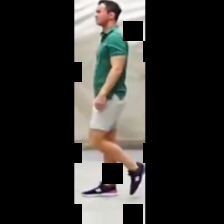

Gender :  [1 0]
Image Quality :  [0 0 1]
Age :  [1 0 0 0 0]
Bag :  [1 0 0]
Pose :  [0 0 1]
Weight :  [0 0 1 0]
Footwear :  [0 0 1]
Emotion :  [0 0 1 0]
Shape:  (224, 224, 3)


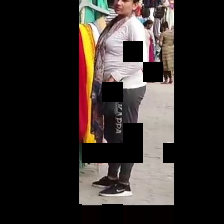

Gender :  [1 0]
Image Quality :  [1 0 0]
Age :  [0 1 0 0 0]
Bag :  [1 0 0]
Pose :  [1 0 0]
Weight :  [1 0 0 0]
Footwear :  [0 1 0]
Emotion :  [0 0 1 0]
Shape:  (224, 224, 3)


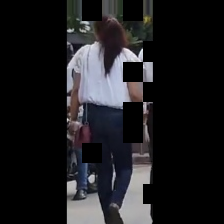

Gender :  [0 1]
Image Quality :  [0 1 0]
Age :  [0 1 0 0 0]
Bag :  [0 0 1]
Pose :  [0 0 1]
Weight :  [1 0 0 0]
Footwear :  [1 0 0]
Emotion :  [0 0 1 0]
Shape:  (224, 224, 3)


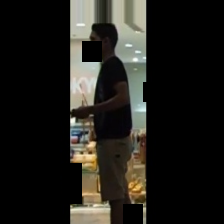

Gender :  [1 0]
Image Quality :  [1 0 0]
Age :  [1 0 0 0 0]
Bag :  [1 0 0]
Pose :  [0 1 0]
Weight :  [1 0 0 0]
Footwear :  [0 1 0]
Emotion :  [0 1 0 0]
Shape:  (224, 224, 3)


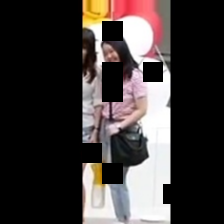

Gender :  [0 1]
Image Quality :  [1 0 0]
Age :  [0 0 1 0 0]
Bag :  [1 0 0]
Pose :  [0 1 0]
Weight :  [1 0 0 0]
Footwear :  [0 0 1]
Emotion :  [0 0 0 1]
Shape:  (224, 224, 3)


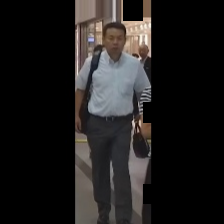

In [0]:
#This is how my data looks like now
for j in range(1, 20):
  print("=====================================")
  print("Gender : " , targets["gender_output"][j])
  print("Image Quality : " , targets["image_quality_output"][j])
  print("Age : " , targets["age_output"][j])
  print("Bag : " , targets["bag_output"][j])
  print("Pose : " , targets["pose_output"][j])
  print("Weight : " , targets["weight_output"][j])
  print("Footwear : ", targets["footwear_output"][j])
  print("Emotion : " , targets["emotion_output"][j])
  print("Shape: ", images[j].shape)
  cv2_imshow(images[j])
  print("=====================================")

Define the RESNET Model

In [0]:
#Define a generic function to add resent layer
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation=True,
                 batch_normalization=True):
   
    #print("Adding Conv2D - filter:", num_filters, " kernel_size:", kernel_size, " strides:", strides)
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    x = conv(x) 
    if batch_normalization:
            x = BatchNormalization()(x)
    if activation:
            x = Activation('relu')(x)

    return x

In [0]:
def resnet_add_indentity_block(inputs, num_filters):
  
  #The main path
  y = resnet_layer(inputs, num_filters=num_filters)
  y = resnet_layer(y, num_filters=num_filters, activation=False)

  x = keras.layers.add([inputs, y])
  x = Activation('relu')(x)
  
  return x

In [0]:
def resnet_add_convulution_block(inputs, num_filters):
  
  #The main path
  y = resnet_layer(inputs, num_filters=num_filters, strides=2)
  y = resnet_layer(y, num_filters=num_filters, activation=False)

  #The shortcut - this has to match the dimensions, hence stride is 2
  x = resnet_layer(inputs, num_filters=num_filters, kernel_size=1, strides=2, activation=False)

  x = keras.layers.add([x, y])
  x = Activation('relu')(x)
  
  return x

In [0]:
#define RESTNET 
def resnet_v1():

  #define the input shape
  inputs=Input(shape=(224, 224, 3))
  #inputs = Input(shape=input_shape)

  num_filters_in = 32

  x = resnet_layer(inputs=inputs, num_filters=num_filters_in) #RF: 3

  #Stage 1
  x = resnet_add_indentity_block(x, num_filters_in) #RF: 3, 7
  x = resnet_add_indentity_block(x, num_filters_in) #RF: 3, 7, 11
  x = resnet_add_indentity_block(x, num_filters_in) #RF: 3, 7, 11, 15

  #Stage 2
  num_filters_in *= 2
  x = resnet_add_convulution_block(x, num_filters_in) #RF: 3, 7, 11, 15, 21
  x = resnet_add_indentity_block(x, num_filters_in) #RF: 3, 7, 11, 15, 21, 29
  x = resnet_add_indentity_block(x, num_filters_in) #RF: 3, 7, 11, 15, 21, 29, 37

  #Stage 3
  num_filters_in *= 2
  x = resnet_add_convulution_block(x, num_filters_in) #RF: 3, 7, 11, 15, 21, 29, 49
  x = resnet_add_indentity_block(x, num_filters_in) #RF: 3, 7, 11, 15, 21, 29, 49, 65
  x = resnet_add_indentity_block(x, num_filters_in) #RF: 3, 7, 11, 15, 21, 29, 49, 81
  x = resnet_add_indentity_block(x, num_filters_in) #RF: 3, 7, 11, 15, 21, 29, 49, 97

  #Stage 4
  num_filters_in *= 2
  x = resnet_add_convulution_block(x, num_filters_in) #RF: 3, 7, 11, 15, 21, 29, 49, 97, 105
  x = resnet_add_indentity_block(x, num_filters_in) #RF: 3, 7, 11, 15, 21, 29, 49, 97, 105, 137
  x = resnet_add_indentity_block(x, num_filters_in) #RF: 3, 7, 11, 15, 21, 29, 49, 97, 105, 137, 169
  x = resnet_add_indentity_block(x, num_filters_in) #RF: 3, 7, 11, 15, 21, 29, 49, 97, 105, 137, 169, 201
  x = resnet_add_indentity_block(x, num_filters_in) #RF: 3, 7, 11, 15, 21, 29, 49, 97, 105, 137, 169, 233

  #Add classifier on top.
  #v1 does not use BN after last shortcut connection-ReLU
  x = AveragePooling2D(pool_size=8)(x)
  x = Flatten()(x)
  x = Dense(512, activation="relu")(x)

  def build_tower(in_layer):
    neck = Dropout(0.2)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = Dropout(0.15)(neck)
    neck = Dense(128, activation="relu")(neck)
    return neck


  def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

  # heads 
  gender = build_head("gender", build_tower(x))
  image_quality = build_head("image_quality", build_tower(x))
  age = build_head("age", build_tower(x))
  weight = build_head("weight", build_tower(x))
  bag = build_head("bag", build_tower(x))
  footwear = build_head("footwear", build_tower(x))
  emotion = build_head("emotion", build_tower(x))
  pose = build_head("pose", build_tower(x))

  outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]

  #Instantiate model.
  model = Model(inputs=inputs, outputs=outputs)
  return model

In [0]:
#Model
model = resnet_v1()














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Callback for Learning Rate (Tapering)

In [0]:
def lr_schedule(epoch):

    lr = 1e-3
    if epoch > 90:
        lr *= 0.5e-3
    elif epoch > 80:
        lr *= 1e-3
    elif epoch > 60:
        lr *= 1e-2
    elif epoch > 40:
        lr *= 1e-1

    print('Learning Rate: ', lr)
    return lr

Callback for Cyclic Learning Rate

In [0]:
from keras.callbacks import Callback
from keras import backend as K
import numpy as np

# Keras-Contib Implementation
class CyclicLR(Callback):

    def __init__(
            self,
            base_lr=0.001,
            max_lr=0.006,
            step_size=2000.,
            mode='triangular',
            gamma=1.,
            scale_fn=None,
            scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        if mode not in ['triangular', 'triangular2',
                        'exp_range']:
            raise KeyError("mode must be one of 'triangular', "
                           "'triangular2', or 'exp_range'")
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1 / (2.**(x - 1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma ** x
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr is not None:
            self.base_lr = new_base_lr
        if new_max_lr is not None:
            self.max_lr = new_max_lr
        if new_step_size is not None:
            self.step_size = new_step_size
        self.clr_iterations = 0.

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(self.clr_iterations)

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):

        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1
        K.set_value(self.model.optimizer.lr, self.clr())

        self.history.setdefault(
            'lr', []).append(
            K.get_value(
                self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        print("Learning Rate: ", float(K.get_value(self.model.optimizer.lr)))
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

Plot Loss, Training & Validation Accuracy

In [0]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []

        self.val_loss = []

        self.gender_acc = []
        self.val_gender_acc = []
        
        self.image_acc = []
        self.val_image_acc = []
        
        self.age_acc = []
        self.val_age_acc = []
        
        self.weight_acc = []
        self.val_weight_acc = []
        
        self.bag_acc = []
        self.val_bag_acc = []
        
        self.footwear_acc = []
        self.val_footwear_acc = []
        
        self.pose_acc = []
        self.val_pose_acc = []
        
        self.emotion_acc = []
        self.val_emotion_acc = []   

        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)

        self.val_loss.append(logs.get('val_loss'))

        self.gender_acc.append(logs.get('gender_output_acc'))
        self.val_gender_acc.append(logs.get('val_gender_output_acc'))

        self.image_acc.append(logs.get('image_quality_output_acc'))
        self.val_image_acc.append(logs.get('val_image_quality_output_acc'))

        self.age_acc.append(logs.get('age_output_acc'))
        self.val_age_acc.append(logs.get('val_age_output_acc'))

        self.weight_acc.append(logs.get('weight_output_acc'))
        self.val_weight_acc.append(logs.get('val_weight_output_acc'))

        self.bag_acc.append(logs.get('bag_output_acc'))
        self.val_bag_acc.append(logs.get('val_bag_output_acc'))

        self.footwear_acc.append(logs.get('footwear_output_acc'))
        self.val_footwear_acc.append(logs.get('val_footwear_output_acc'))

        self.pose_acc.append(logs.get('pose_output_acc'))
        self.val_pose_acc.append(logs.get('val_pose_output_acc'))

        self.emotion_acc.append(logs.get('emotion_output_acc'))
        self.val_emotion_acc.append(logs.get('val_emotion_output_acc'))

        self.i += 1    
        
        if (self.i % 10) == 0:
          #print("===========Here after 10=========")

          f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9) = plt.subplots(nrows=1, ncols=9, figsize=(30, 4), sharex=True)
        
          ax1.plot(self.x, self.val_loss, label="val_loss")
          ax1.legend()

          ax2.plot(self.x, self.gender_acc, label="gender_accuracy")
          ax2.plot(self.x, self.val_gender_acc, label="gender_val_accuracy")
          ax2.legend()

          ax3.plot(self.x, self.image_acc, label="image_accuracy")
          ax3.plot(self.x, self.val_image_acc, label="image_val_accuracy")
          ax3.legend()

          ax4.plot(self.x, self.age_acc, label="age_accuracy")
          ax4.plot(self.x, self.val_age_acc, label="age_val_accuracy")
          ax4.legend()

          ax5.plot(self.x, self.weight_acc, label="weight_accuracy")
          ax5.plot(self.x, self.val_weight_acc, label="weight_val_accuracy")
          ax5.legend()

          ax6.plot(self.x, self.bag_acc, label="bag_accuracy")
          ax6.plot(self.x, self.val_bag_acc, label="bag_val_accuracy")
          ax6.legend()

          ax7.plot(self.x, self.footwear_acc, label="footwear_accuracy")
          ax7.plot(self.x, self.val_footwear_acc, label="footwear_val_accuracy")
          ax7.legend()

          ax8.plot(self.x, self.emotion_acc, label="emotion_accuracy")
          ax8.plot(self.x, self.val_emotion_acc, label="emotion_val_accuracy")
          ax8.legend()

          ax9.plot(self.x, self.pose_acc, label="pose_accuracy")
          ax9.plot(self.x, self.val_pose_acc, label="pose_val_accuracy")
          ax9.legend()
        
          plt.show();
        
plot = PlotLearning()

Callback to Save Model Weights after every 10 Epocs

In [0]:
class SaveWeights(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0 
        self.ep = 0  

    def on_epoch_end(self, epoch, logs={}):
        
        self.i += 1
        self.ep = epoch + 1
        #print("Self I: ", self.i, " Epoch: ", self.ep)
        if (self.i % 10) == 0:
              model.save_weights(f"/content/gdrive/My Drive/dataset/training20/Assignment5_RESNET__{self.ep}.hdf5")
              print("Saved the Model after Epoch: ", self.i)
        
save_weight = SaveWeights()

In [0]:
opt = SGD(lr=0.001, momentum=0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Prepare callbacks for model saving and for learning rate adjustment.

filepath='/content/gdrive/My Drive/dataset/training20/autosaved/resnet-epochs:{epoch:03d}-validation.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath,
                             verbose=1,
                             save_best_only=True)

clr = CyclicLR(base_lr=0.001, 
               max_lr=0.006, 
               step_size=2000., 
               mode='triangular')

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, clr, plot, save_weight]

In [0]:
#Print Model Summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 224, 224, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

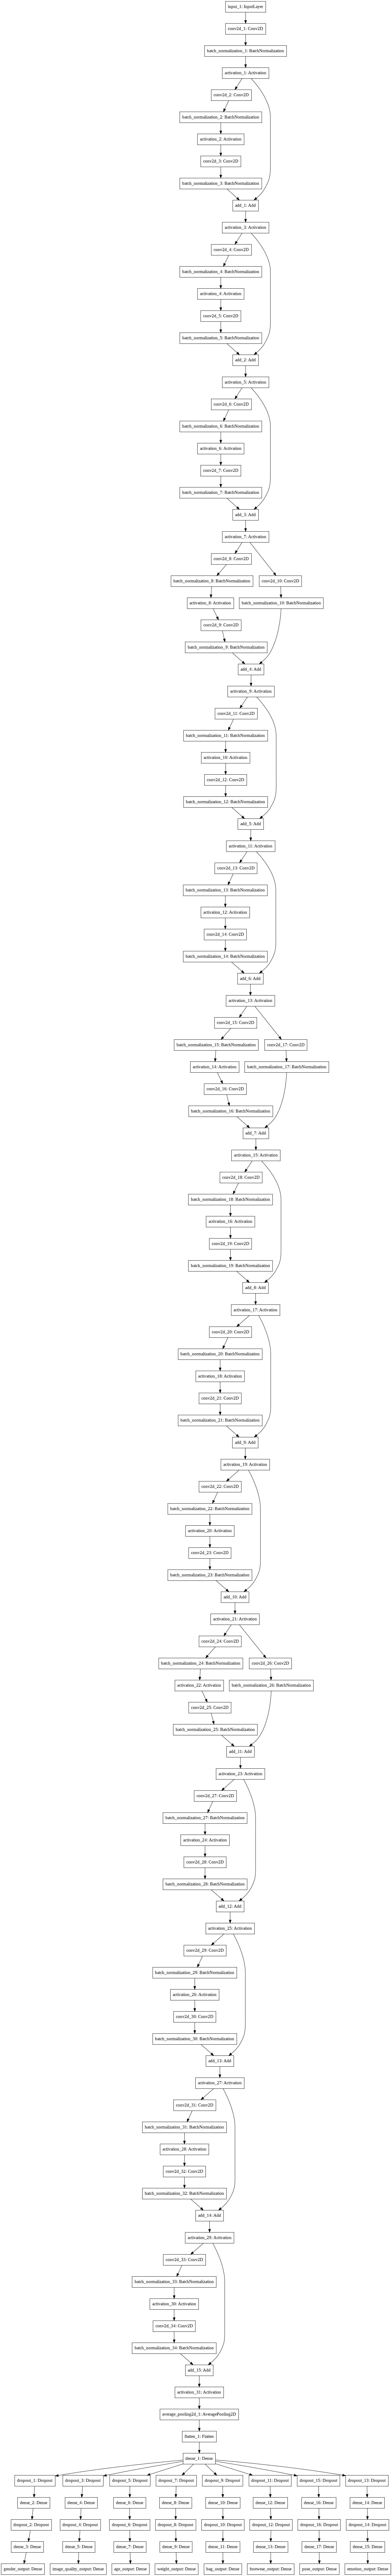

In [0]:
#Visualize Model
plot_model(model, to_file='model.png')

In [0]:
last_executed_epoch = 0
nb_epoch = 150

Training for Epochs : 1 - 150 -------------------------------
Epoch 1/150
360/360 [==============================] - 202s 561ms/step - loss: 8.9004 - gender_output_loss: 0.6846 - image_quality_output_loss: 1.0001 - age_output_loss: 1.4527 - weight_output_loss: 1.0087 - bag_output_loss: 0.9346 - footwear_output_loss: 1.0093 - pose_output_loss: 0.9492 - emotion_output_loss: 0.9346 - gender_output_acc: 0.5603 - image_quality_output_acc: 0.5390 - age_output_acc: 0.3836 - weight_output_acc: 0.6310 - bag_output_acc: 0.5490 - footwear_output_acc: 0.4960 - pose_output_acc: 0.6117 - emotion_output_acc: 0.7123 - val_loss: 8.8696 - val_gender_output_loss: 0.6745 - val_image_quality_output_loss: 0.9974 - val_age_output_loss: 1.4551 - val_weight_output_loss: 1.0016 - val_bag_output_loss: 0.9274 - val_footwear_output_loss: 0.9814 - val_pose_output_loss: 0.9594 - val_emotion_output_loss: 0.9473 - val_gender_output_acc: 0.5731 - val_image_quality_output_acc: 0.5645 - val_age_output_acc: 0.3871 - val_w

<Figure size 432x288 with 0 Axes>

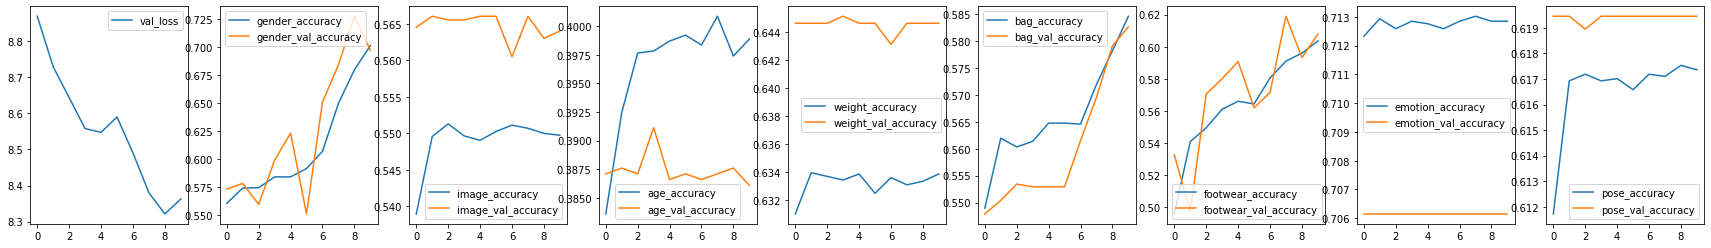

Saved the Model after Epoch:  10
Epoch 11/150
360/360 [==============================] - 195s 542ms/step - loss: 8.3194 - gender_output_loss: 0.5478 - image_quality_output_loss: 0.9776 - age_output_loss: 1.3996 - weight_output_loss: 0.9735 - bag_output_loss: 0.8816 - footwear_output_loss: 0.8563 - pose_output_loss: 0.9094 - emotion_output_loss: 0.8930 - gender_output_acc: 0.7173 - image_quality_output_acc: 0.5523 - age_output_acc: 0.3998 - weight_output_acc: 0.6333 - bag_output_acc: 0.5865 - footwear_output_acc: 0.6084 - pose_output_acc: 0.6172 - emotion_output_acc: 0.7128 - val_loss: 8.3026 - val_gender_output_loss: 0.5441 - val_image_quality_output_loss: 0.9601 - val_age_output_loss: 1.3992 - val_weight_output_loss: 0.9710 - val_bag_output_loss: 0.8718 - val_footwear_output_loss: 0.8548 - val_pose_output_loss: 0.9124 - val_emotion_output_loss: 0.9096 - val_gender_output_acc: 0.7268 - val_image_quality_output_acc: 0.5670 - val_age_output_acc: 0.3861 - val_weight_output_acc: 0.6447 - v

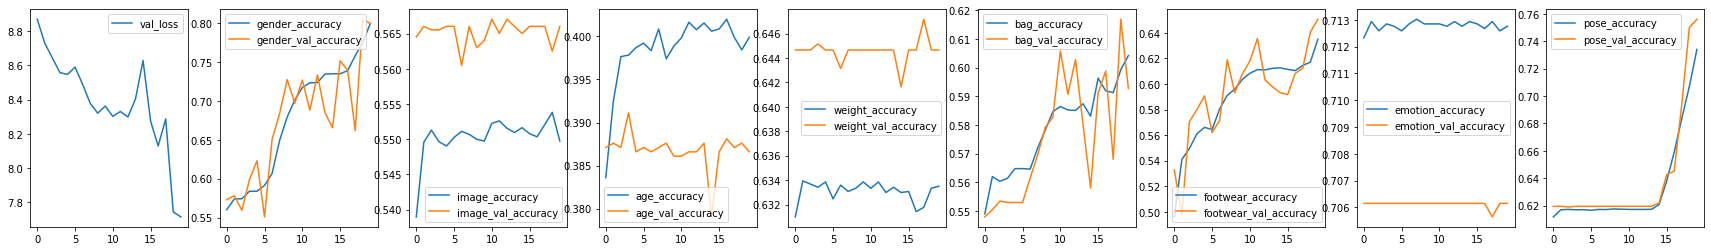

Saved the Model after Epoch:  20
Epoch 21/150
359/360 [============================>.] - ETA: 0s - loss: 7.7396 - gender_output_loss: 0.4141 - image_quality_output_loss: 0.9720 - age_output_loss: 1.3931 - weight_output_loss: 0.9743 - bag_output_loss: 0.8620 - footwear_output_loss: 0.8084 - pose_output_loss: 0.6015 - emotion_output_loss: 0.8714 - gender_output_acc: 0.8122 - image_quality_output_acc: 0.5544 - age_output_acc: 0.4027 - weight_output_acc: 0.6340 - bag_output_acc: 0.6080 - footwear_output_acc: 0.6415 - pose_output_acc: 0.7464 - emotion_output_acc: 0.7128
Epoch 00020: val_loss improved from 7.74461 to 7.71549, saving model to /content/gdrive/My Drive/dataset/training20/autosaved/resnet-epochs:020-validation.hdf5
360/360 [==============================] - 197s 549ms/step - loss: 7.7384 - gender_output_loss: 0.4144 - image_quality_output_loss: 0.9719 - age_output_loss: 1.3928 - weight_output_loss: 0.9738 - bag_output_loss: 0.8616 - footwear_output_loss: 0.8084 - pose_output_los

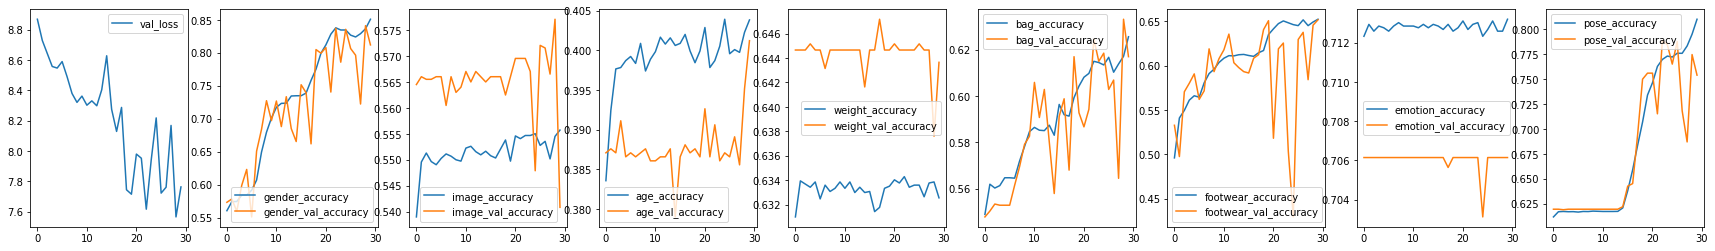

Saved the Model after Epoch:  30
Epoch 31/150
360/360 [==============================] - 193s 536ms/step - loss: 7.3284 - gender_output_loss: 0.3245 - image_quality_output_loss: 0.9298 - age_output_loss: 1.3771 - weight_output_loss: 0.9552 - bag_output_loss: 0.8370 - footwear_output_loss: 0.7709 - pose_output_loss: 0.4648 - emotion_output_loss: 0.8579 - gender_output_acc: 0.8621 - image_quality_output_acc: 0.5603 - age_output_acc: 0.4067 - weight_output_acc: 0.6343 - bag_output_acc: 0.6279 - footwear_output_acc: 0.6628 - pose_output_acc: 0.8226 - emotion_output_acc: 0.7130 - val_loss: 7.4318 - val_gender_output_loss: 0.3192 - val_image_quality_output_loss: 0.8987 - val_age_output_loss: 1.3767 - val_weight_output_loss: 0.9481 - val_bag_output_loss: 0.8385 - val_footwear_output_loss: 0.7689 - val_pose_output_loss: 0.5898 - val_emotion_output_loss: 0.8822 - val_gender_output_acc: 0.8664 - val_image_quality_output_acc: 0.5786 - val_age_output_acc: 0.3891 - val_weight_output_acc: 0.6467 - v

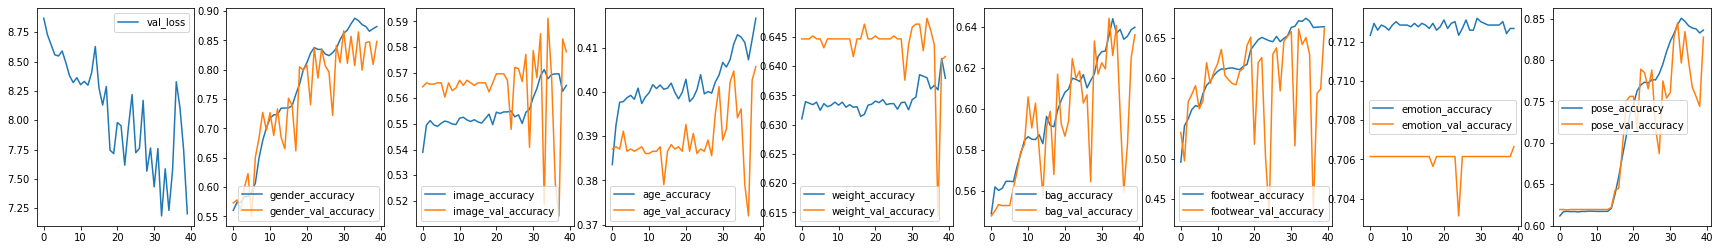

Saved the Model after Epoch:  40
Epoch 41/150
360/360 [==============================] - 193s 536ms/step - loss: 7.0807 - gender_output_loss: 0.2915 - image_quality_output_loss: 0.9016 - age_output_loss: 1.3361 - weight_output_loss: 0.9283 - bag_output_loss: 0.8137 - footwear_output_loss: 0.7616 - pose_output_loss: 0.4077 - emotion_output_loss: 0.8556 - gender_output_acc: 0.8775 - image_quality_output_acc: 0.5706 - age_output_acc: 0.4151 - weight_output_acc: 0.6419 - bag_output_acc: 0.6470 - footwear_output_acc: 0.6669 - pose_output_acc: 0.8469 - emotion_output_acc: 0.7128 - val_loss: 7.2535 - val_gender_output_loss: 0.3093 - val_image_quality_output_loss: 0.9107 - val_age_output_loss: 1.3394 - val_weight_output_loss: 0.9278 - val_bag_output_loss: 0.8104 - val_footwear_output_loss: 0.8304 - val_pose_output_loss: 0.4667 - val_emotion_output_loss: 0.8760 - val_gender_output_acc: 0.8765 - val_image_quality_output_acc: 0.5882 - val_age_output_acc: 0.4073 - val_weight_output_acc: 0.6436 - v

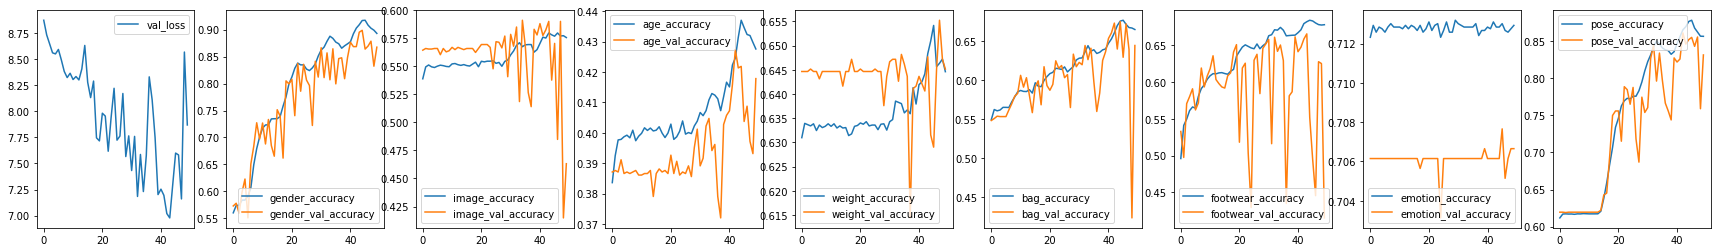

Saved the Model after Epoch:  50
Epoch 51/150
360/360 [==============================] - 192s 533ms/step - loss: 6.8674 - gender_output_loss: 0.2611 - image_quality_output_loss: 0.8865 - age_output_loss: 1.3016 - weight_output_loss: 0.9023 - bag_output_loss: 0.7776 - footwear_output_loss: 0.7431 - pose_output_loss: 0.3866 - emotion_output_loss: 0.8472 - gender_output_acc: 0.8938 - image_quality_output_acc: 0.5759 - age_output_acc: 0.4318 - weight_output_acc: 0.6490 - bag_output_acc: 0.6731 - footwear_output_acc: 0.6772 - pose_output_acc: 0.8567 - emotion_output_acc: 0.7128 - val_loss: 7.1527 - val_gender_output_loss: 0.3176 - val_image_quality_output_loss: 0.8954 - val_age_output_loss: 1.2995 - val_weight_output_loss: 0.9099 - val_bag_output_loss: 0.8108 - val_footwear_output_loss: 0.8791 - val_pose_output_loss: 0.4107 - val_emotion_output_loss: 0.8697 - val_gender_output_acc: 0.8634 - val_image_quality_output_acc: 0.5731 - val_age_output_acc: 0.4254 - val_weight_output_acc: 0.6421 - v

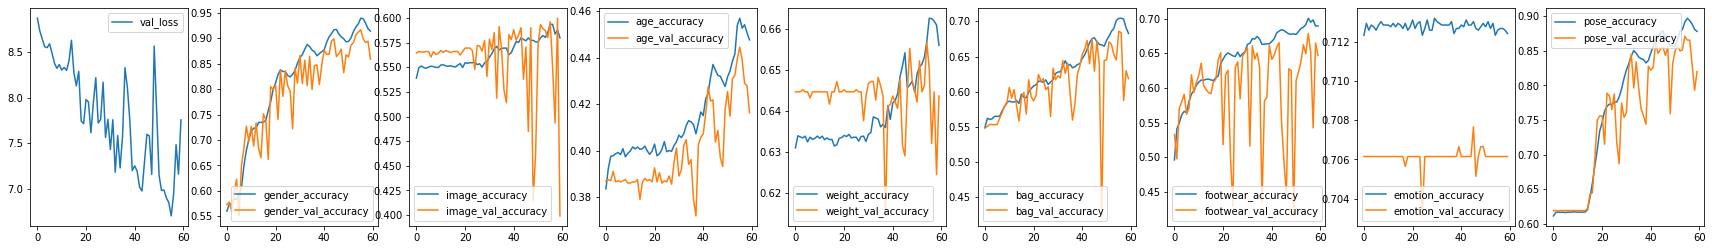

Saved the Model after Epoch:  60
Epoch 61/150
359/360 [============================>.] - ETA: 0s - loss: 6.6257 - gender_output_loss: 0.2266 - image_quality_output_loss: 0.8668 - age_output_loss: 1.2562 - weight_output_loss: 0.8702 - bag_output_loss: 0.7465 - footwear_output_loss: 0.7251 - pose_output_loss: 0.3497 - emotion_output_loss: 0.8429 - gender_output_acc: 0.9109 - image_quality_output_acc: 0.5854 - age_output_acc: 0.4407 - weight_output_acc: 0.6582 - bag_output_acc: 0.6935 - footwear_output_acc: 0.6868 - pose_output_acc: 0.8724 - emotion_output_acc: 0.7136
Epoch 00060: val_loss did not improve from 6.70566
360/360 [==============================] - 193s 535ms/step - loss: 6.6241 - gender_output_loss: 0.2262 - image_quality_output_loss: 0.8668 - age_output_loss: 1.2555 - weight_output_loss: 0.8700 - bag_output_loss: 0.7464 - footwear_output_loss: 0.7250 - pose_output_loss: 0.3496 - emotion_output_loss: 0.8430 - gender_output_acc: 0.9111 - image_quality_output_acc: 0.5855 - age_

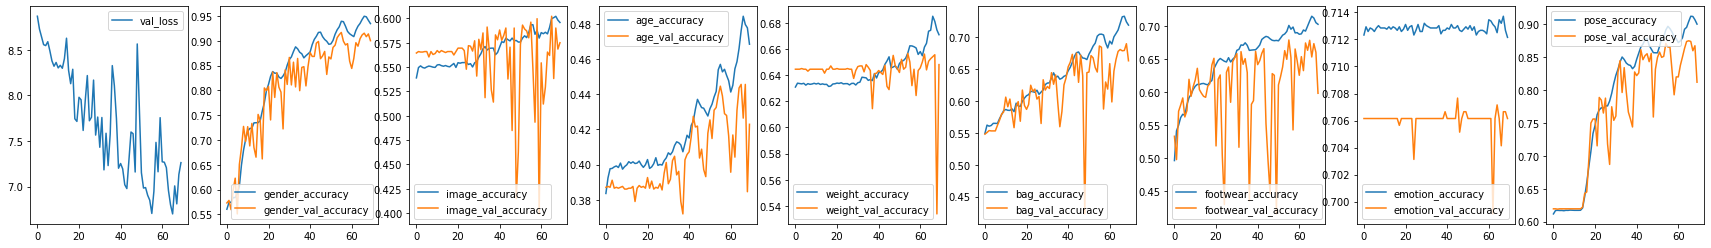

Saved the Model after Epoch:  70
Epoch 71/150
360/360 [==============================] - 197s 547ms/step - loss: 6.3078 - gender_output_loss: 0.1830 - image_quality_output_loss: 0.8539 - age_output_loss: 1.1951 - weight_output_loss: 0.8207 - bag_output_loss: 0.7083 - footwear_output_loss: 0.6916 - pose_output_loss: 0.2992 - emotion_output_loss: 0.8313 - gender_output_acc: 0.9328 - image_quality_output_acc: 0.5852 - age_output_acc: 0.4668 - weight_output_acc: 0.6704 - bag_output_acc: 0.7122 - footwear_output_acc: 0.6972 - pose_output_acc: 0.8939 - emotion_output_acc: 0.7132 - val_loss: 7.0905 - val_gender_output_loss: 0.3073 - val_image_quality_output_loss: 0.9349 - val_age_output_loss: 1.3195 - val_weight_output_loss: 0.9238 - val_bag_output_loss: 0.7602 - val_footwear_output_loss: 0.7871 - val_pose_output_loss: 0.4501 - val_emotion_output_loss: 0.8835 - val_gender_output_acc: 0.8770 - val_image_quality_output_acc: 0.5449 - val_age_output_acc: 0.4340 - val_weight_output_acc: 0.6502 - v

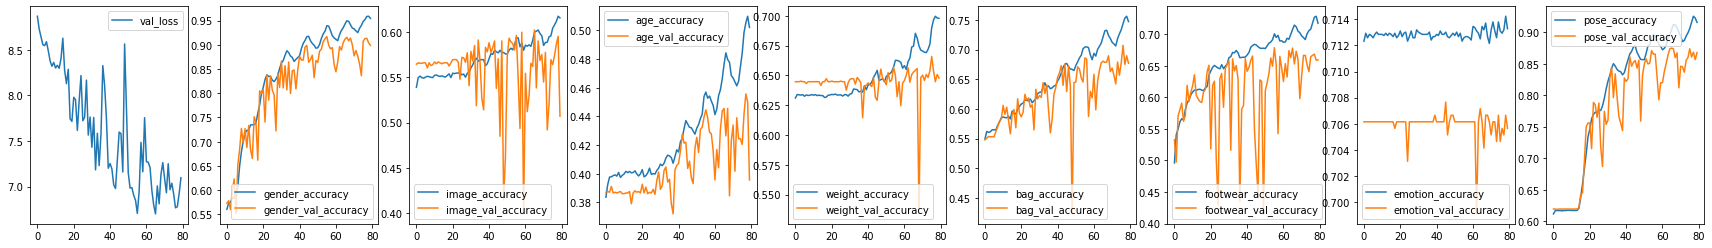

Saved the Model after Epoch:  80
Epoch 81/150
360/360 [==============================] - 198s 551ms/step - loss: 5.9799 - gender_output_loss: 0.1473 - image_quality_output_loss: 0.8289 - age_output_loss: 1.1362 - weight_output_loss: 0.7603 - bag_output_loss: 0.6587 - footwear_output_loss: 0.6664 - pose_output_loss: 0.2474 - emotion_output_loss: 0.8228 - gender_output_acc: 0.9470 - image_quality_output_acc: 0.6069 - age_output_acc: 0.4927 - weight_output_acc: 0.6885 - bag_output_acc: 0.7380 - footwear_output_acc: 0.7082 - pose_output_acc: 0.9101 - emotion_output_acc: 0.7141 - val_loss: 7.4711 - val_gender_output_loss: 0.3369 - val_image_quality_output_loss: 0.8919 - val_age_output_loss: 1.3090 - val_weight_output_loss: 1.0266 - val_bag_output_loss: 0.9386 - val_footwear_output_loss: 0.9143 - val_pose_output_loss: 0.4477 - val_emotion_output_loss: 0.8945 - val_gender_output_acc: 0.8816 - val_image_quality_output_acc: 0.5832 - val_age_output_acc: 0.4259 - val_weight_output_acc: 0.5746 - v

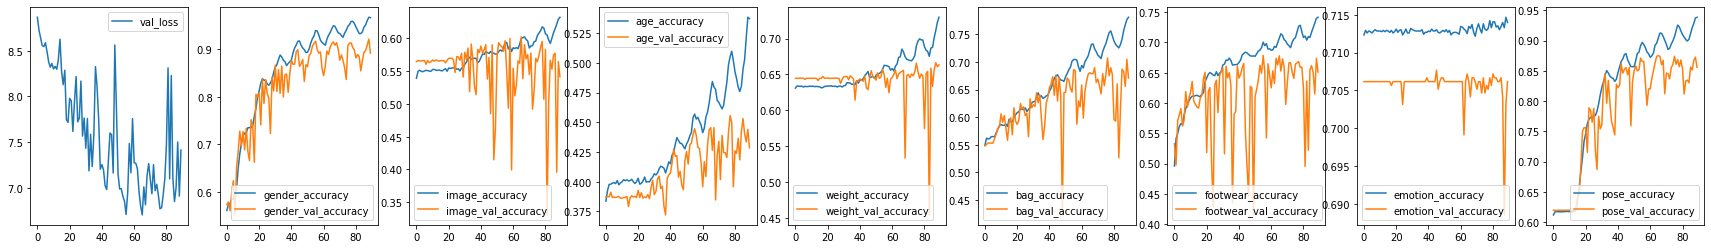

Saved the Model after Epoch:  90
Epoch 91/150
360/360 [==============================] - 195s 541ms/step - loss: 5.5545 - gender_output_loss: 0.1077 - image_quality_output_loss: 0.7909 - age_output_loss: 1.0593 - weight_output_loss: 0.6846 - bag_output_loss: 0.5896 - footwear_output_loss: 0.6147 - pose_output_loss: 0.1988 - emotion_output_loss: 0.8046 - gender_output_acc: 0.9607 - image_quality_output_acc: 0.6201 - age_output_acc: 0.5216 - weight_output_acc: 0.7197 - bag_output_acc: 0.7704 - footwear_output_acc: 0.7341 - pose_output_acc: 0.9293 - emotion_output_acc: 0.7144 - val_loss: 7.2948 - val_gender_output_loss: 0.2640 - val_image_quality_output_loss: 1.0695 - val_age_output_loss: 1.3358 - val_weight_output_loss: 0.9190 - val_bag_output_loss: 0.7801 - val_footwear_output_loss: 0.8337 - val_pose_output_loss: 0.4858 - val_emotion_output_loss: 0.9030 - val_gender_output_acc: 0.9158 - val_image_quality_output_acc: 0.4864 - val_age_output_acc: 0.4219 - val_weight_output_acc: 0.6416 - v

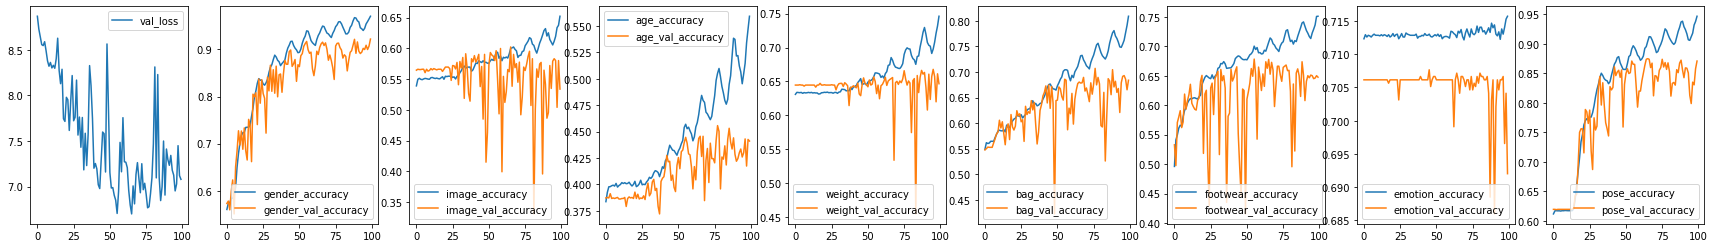

Saved the Model after Epoch:  100
Epoch 101/150
360/360 [==============================] - 198s 550ms/step - loss: 5.0662 - gender_output_loss: 0.0783 - image_quality_output_loss: 0.7398 - age_output_loss: 0.9632 - weight_output_loss: 0.5959 - bag_output_loss: 0.4916 - footwear_output_loss: 0.5583 - pose_output_loss: 0.1490 - emotion_output_loss: 0.7870 - gender_output_acc: 0.9738 - image_quality_output_acc: 0.6545 - age_output_acc: 0.5727 - weight_output_acc: 0.7563 - bag_output_acc: 0.8143 - footwear_output_acc: 0.7604 - pose_output_acc: 0.9469 - emotion_output_acc: 0.7151 - val_loss: 7.4487 - val_gender_output_loss: 0.2838 - val_image_quality_output_loss: 0.9308 - val_age_output_loss: 1.4008 - val_weight_output_loss: 1.0112 - val_bag_output_loss: 0.8705 - val_footwear_output_loss: 0.7927 - val_pose_output_loss: 0.5379 - val_emotion_output_loss: 0.9182 - val_gender_output_acc: 0.9103 - val_image_quality_output_acc: 0.5736 - val_age_output_acc: 0.4506 - val_weight_output_acc: 0.6512 -

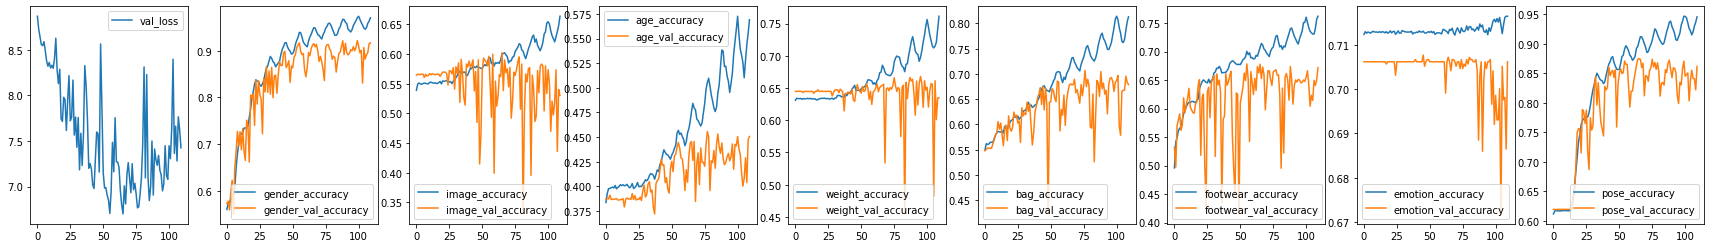

Saved the Model after Epoch:  110
Epoch 111/150
360/360 [==============================] - 198s 551ms/step - loss: 4.8095 - gender_output_loss: 0.0745 - image_quality_output_loss: 0.7011 - age_output_loss: 0.9064 - weight_output_loss: 0.5567 - bag_output_loss: 0.4379 - footwear_output_loss: 0.5270 - pose_output_loss: 0.1284 - emotion_output_loss: 0.7681 - gender_output_acc: 0.9748 - image_quality_output_acc: 0.6777 - age_output_acc: 0.5955 - weight_output_acc: 0.7706 - bag_output_acc: 0.8327 - footwear_output_acc: 0.7714 - pose_output_acc: 0.9538 - emotion_output_acc: 0.7200 - val_loss: 7.5284 - val_gender_output_loss: 0.3560 - val_image_quality_output_loss: 1.0379 - val_age_output_loss: 1.3586 - val_weight_output_loss: 0.9947 - val_bag_output_loss: 0.8966 - val_footwear_output_loss: 0.7826 - val_pose_output_loss: 0.4896 - val_emotion_output_loss: 0.9032 - val_gender_output_acc: 0.9118 - val_image_quality_output_acc: 0.5292 - val_age_output_acc: 0.4637 - val_weight_output_acc: 0.6537 -

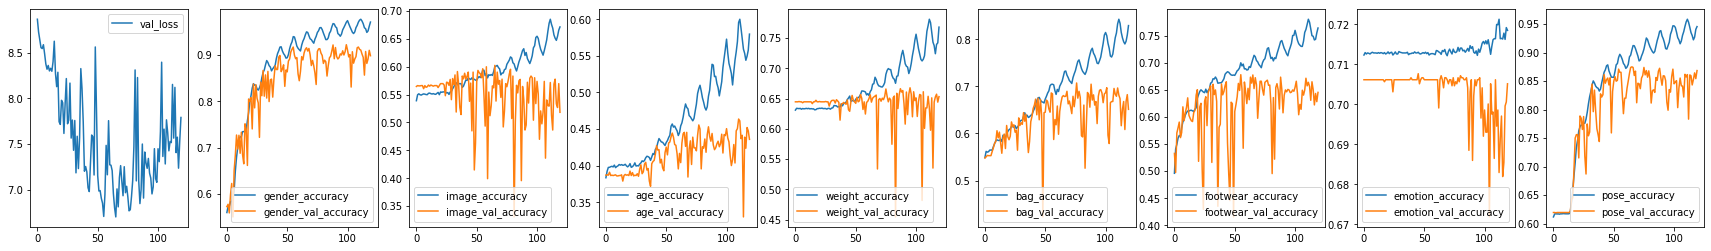

Saved the Model after Epoch:  120
Epoch 121/150
359/360 [============================>.] - ETA: 0s - loss: 4.7312 - gender_output_loss: 0.0792 - image_quality_output_loss: 0.6858 - age_output_loss: 0.8969 - weight_output_loss: 0.5322 - bag_output_loss: 0.4095 - footwear_output_loss: 0.5175 - pose_output_loss: 0.1312 - emotion_output_loss: 0.7561 - gender_output_acc: 0.9704 - image_quality_output_acc: 0.6866 - age_output_acc: 0.6018 - weight_output_acc: 0.7854 - bag_output_acc: 0.8424 - footwear_output_acc: 0.7786 - pose_output_acc: 0.9529 - emotion_output_acc: 0.7215
Epoch 00120: val_loss did not improve from 6.70042
Learning Rate:  0.0029674998950213194
360/360 [==============================] - 193s 536ms/step - loss: 4.7337 - gender_output_loss: 0.0791 - image_quality_output_loss: 0.6861 - age_output_loss: 0.8970 - weight_output_loss: 0.5324 - bag_output_loss: 0.4102 - footwear_output_loss: 0.5176 - pose_output_loss: 0.1314 - emotion_output_loss: 0.7572 - gender_output_acc: 0.9704 -

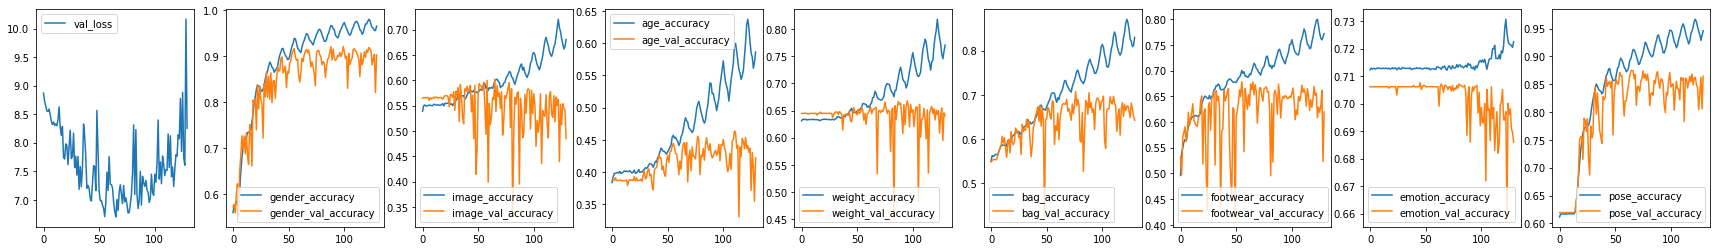

Saved the Model after Epoch:  130
Epoch 131/150
360/360 [==============================] - 193s 537ms/step - loss: 4.6556 - gender_output_loss: 0.0816 - image_quality_output_loss: 0.6609 - age_output_loss: 0.8944 - weight_output_loss: 0.5126 - bag_output_loss: 0.3893 - footwear_output_loss: 0.4986 - pose_output_loss: 0.1373 - emotion_output_loss: 0.7390 - gender_output_acc: 0.9710 - image_quality_output_acc: 0.7013 - age_output_acc: 0.6043 - weight_output_acc: 0.7847 - bag_output_acc: 0.8507 - footwear_output_acc: 0.7867 - pose_output_acc: 0.9512 - emotion_output_acc: 0.7263 - val_loss: 7.9753 - val_gender_output_loss: 0.3211 - val_image_quality_output_loss: 1.1057 - val_age_output_loss: 1.4272 - val_weight_output_loss: 1.0923 - val_bag_output_loss: 0.9764 - val_footwear_output_loss: 0.8952 - val_pose_output_loss: 0.4733 - val_emotion_output_loss: 0.9419 - val_gender_output_acc: 0.9027 - val_image_quality_output_acc: 0.5373 - val_age_output_acc: 0.4466 - val_weight_output_acc: 0.6406 -

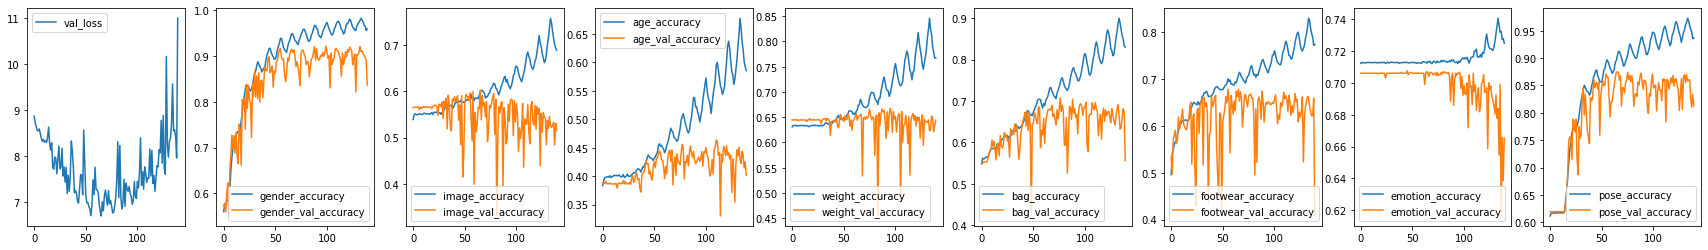

Saved the Model after Epoch:  140
Epoch 141/150
359/360 [============================>.] - ETA: 0s - loss: 4.6180 - gender_output_loss: 0.0847 - image_quality_output_loss: 0.6403 - age_output_loss: 0.8709 - weight_output_loss: 0.5191 - bag_output_loss: 0.3874 - footwear_output_loss: 0.4897 - pose_output_loss: 0.1386 - emotion_output_loss: 0.7224 - gender_output_acc: 0.9689 - image_quality_output_acc: 0.7108 - age_output_acc: 0.6218 - weight_output_acc: 0.7837 - bag_output_acc: 0.8514 - footwear_output_acc: 0.7919 - pose_output_acc: 0.9507 - emotion_output_acc: 0.7306
Epoch 00140: val_loss did not improve from 6.70042
360/360 [==============================] - 193s 536ms/step - loss: 4.6169 - gender_output_loss: 0.0845 - image_quality_output_loss: 0.6401 - age_output_loss: 0.8706 - weight_output_loss: 0.5189 - bag_output_loss: 0.3878 - footwear_output_loss: 0.4892 - pose_output_loss: 0.1383 - emotion_output_loss: 0.7225 - gender_output_acc: 0.9690 - image_quality_output_acc: 0.7108 - ag

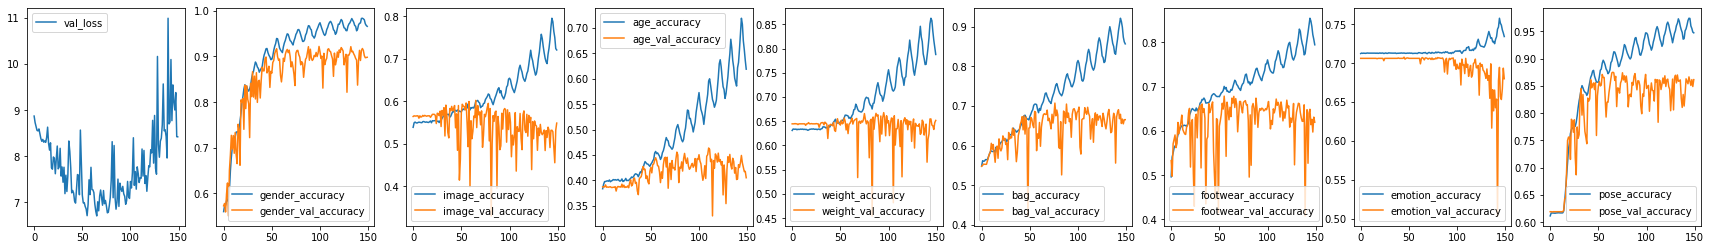

Saved the Model after Epoch:  150
----------------------------------------- Model weights saved to Google Drive -----------------------------------------


In [0]:
print('Training for Epochs : ' + str(last_executed_epoch+1) + ' - ' + str(nb_epoch) + " -------------------------------")

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(generator=train_gen, validation_data=valid_gen, use_multiprocessing=True, epochs=nb_epoch, initial_epoch=last_executed_epoch, verbose=1, workers=6, callbacks=callbacks)

print('----------------------------------------- Model weights saved to Google Drive -----------------------------------------')

In [0]:
def evaluate_model(model):
    results = model.evaluate_generator(valid_gen, verbose=1)
    accuracies = {}
    losses = {}
    for k, v in zip(model.metrics_names, results):
        if k.endswith('acc'):
            accuracies[k] = round(v * 100, 4) 
        else:
            losses[k] = v
    return accuracies, losses

In [0]:
#Evaluate after Training for 150 epcohs
evaluate_model(model)

31/31 [==============================] - 10s 307ms/step


({'age_output_acc': 40.5242,
  'bag_output_acc': 66.5323,
  'emotion_output_acc': 67.994,
  'footwear_output_acc': 61.9456,
  'gender_output_acc': 89.8185,
  'image_quality_output_acc': 54.8891,
  'pose_output_acc': 86.1391,
  'weight_output_acc': 65.1714},
 {'age_output_loss': 1.7970551675365818,
  'bag_output_loss': 0.9875839218016593,
  'emotion_output_loss': 0.9593665926687179,
  'footwear_output_loss': 0.8816747011676911,
  'gender_output_loss': 0.34586082038379484,
  'image_quality_output_loss': 0.9913544962483067,
  'loss': 8.418590391835858,
  'pose_output_loss': 0.5421295339061368,
  'weight_output_loss': 1.1271546963722474})

In [0]:
#The Loss is minimum at 66th Epoch, Load the weights after 66th Epoch
model.load_weights("/content/gdrive/My Drive/dataset/training20/autosaved/resnet-epochs:066-validation.hdf5")
#Evalue based on 66th epoch 
evaluate_model(model)

31/31 [==============================] - 9s 305ms/step


({'age_output_acc': 44.5565,
  'bag_output_acc': 68.0444,
  'emotion_output_acc': 70.6149,
  'footwear_output_acc': 67.7923,
  'gender_output_acc': 91.1794,
  'image_quality_output_acc': 60.2319,
  'pose_output_acc': 87.5,
  'weight_output_acc': 65.2722},
 {'age_output_loss': 1.2322431533567366,
  'bag_output_loss': 0.7689242603317383,
  'emotion_output_loss': 0.8736067375829143,
  'footwear_output_loss': 0.7395062196639276,
  'gender_output_loss': 0.24393252091061685,
  'image_quality_output_loss': 0.8632284306710766,
  'loss': 6.7004177185796925,
  'pose_output_loss': 0.38229226729562205,
  'weight_output_loss': 0.8661872129286489})

How to Visualize Filters

In [0]:
# summarize filters in each convolutional layer
from keras.applications.vgg16 import VGG16
from matplotlib import pyplot
# summarize filter shapes
for layer in model.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

conv2d_1 (3, 3, 3, 32)
conv2d_2 (3, 3, 32, 32)
conv2d_3 (3, 3, 32, 32)
conv2d_4 (3, 3, 32, 32)
conv2d_5 (3, 3, 32, 32)
conv2d_6 (3, 3, 32, 32)
conv2d_7 (3, 3, 32, 32)
conv2d_8 (3, 3, 32, 64)
conv2d_10 (1, 1, 32, 64)
conv2d_9 (3, 3, 64, 64)
conv2d_11 (3, 3, 64, 64)
conv2d_12 (3, 3, 64, 64)
conv2d_13 (3, 3, 64, 64)
conv2d_14 (3, 3, 64, 64)
conv2d_15 (3, 3, 64, 128)
conv2d_17 (1, 1, 64, 128)
conv2d_16 (3, 3, 128, 128)
conv2d_18 (3, 3, 128, 128)
conv2d_19 (3, 3, 128, 128)
conv2d_20 (3, 3, 128, 128)
conv2d_21 (3, 3, 128, 128)
conv2d_22 (3, 3, 128, 128)
conv2d_23 (3, 3, 128, 128)
conv2d_24 (3, 3, 128, 256)
conv2d_26 (1, 1, 128, 256)
conv2d_25 (3, 3, 256, 256)
conv2d_27 (3, 3, 256, 256)
conv2d_28 (3, 3, 256, 256)
conv2d_29 (3, 3, 256, 256)
conv2d_30 (3, 3, 256, 256)
conv2d_31 (3, 3, 256, 256)
conv2d_32 (3, 3, 256, 256)
conv2d_33 (3, 3, 256, 256)
conv2d_34 (3, 3, 256, 256)


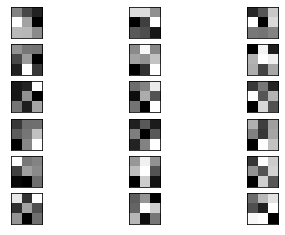

In [0]:
# cannot easily visualize filters lower down
from matplotlib import pyplot
# retrieve weights from the second hidden layer
filters, biases = model.layers[1].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = pyplot.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

Visualize Feature Maps

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
Total params: 896
Trainable params: 896
Non-trainable params: 0
_________________________________________________________________


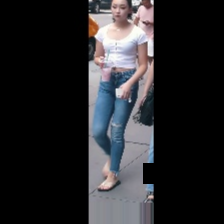

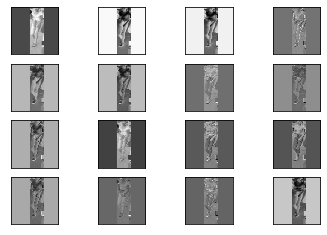

In [0]:
# plot feature map of first conv layer for given image
#from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
# load the model
#model = VGG16()
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[1].output)
model.summary()
# load the image with the required shape
#img = load_img(images[2], target_size=(224, 224))
# convert the image to an array
cv2_imshow(images[5])
img = img_to_array(images[5])
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 4
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
pyplot.show()